<a href="https://colab.research.google.com/github/sreent/machine-learning/blob/main/Final%20DNN%20Code%20Examples/German%20Credit%20Data/German%20Credit%20Data%20-%20SMOTE%20Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# German Credit Data - SMOTE Example

This notebook demonstrates the **Universal ML Workflow** using **SMOTE (Synthetic Minority Over-sampling Technique)** to handle class imbalance - an alternative to class weights.

## Learning Objectives

By the end of this notebook, you will be able to:
- Understand the difference between **class weights** and **oversampling** approaches to handle imbalance
- Apply **SMOTE** to generate synthetic samples of the minority class
- Properly evaluate models when using SMOTE (train on balanced, validate on imbalanced)
- Handle mixed feature types with One-Hot Encoding and Standardization
- Compare model performance on balanced vs. imbalanced validation data

---

## Dataset Overview

| Attribute | Description |
|-----------|-------------|
| **Source** | [UCI German Credit Data](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)) |
| **Problem Type** | Binary Classification (Good/Bad Credit Risk) |
| **Data Balance** | Imbalanced (70% Good, 30% Bad) |
| **Data Type** | Structured (Mixed Categorical & Numerical) |
| **Features** | 7 numerical + 13 categorical variables |
| **Imbalance Handling** | SMOTE oversampling |

---

## SMOTE vs. Class Weights

| Approach | How It Works | Pros | Cons |
|----------|--------------|------|------|
| **Class Weights** | Penalize misclassifying minority class more | Simple, no data modification | May not fully solve imbalance |
| **SMOTE** | Generate synthetic minority samples | Creates more training data | May introduce noise, computationally expensive |

---

## 1. Defining the Problem and Assembling a Dataset

**Problem Statement:** Classify credit applicants as good or bad credit risks based on their financial and personal attributes.

**Business Context:** Banks need to assess credit risk to:
- Minimize loan defaults
- Offer appropriate interest rates
- Make fair lending decisions

**Data Source:** This classic dataset from UCI Machine Learning Repository contains 1000 instances with 20 attributes describing credit applicants.

<a href="https://colab.research.google.com/github/sreent/machine-learning/blob/main/Final%20DNN%20Code%20Examples/German%20Credit%20Data/German%20Credit%20Data%20-%20SMOTE%20Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# German Credit Data - SMOTE Example

This notebook demonstrates the **Universal ML Workflow** applied to an imbalanced binary classification problem using SMOTE for oversampling.

## 2. Choosing a Measure of Success

| Metric | Description | Why We Use It |
|--------|-------------|---------------|
| **Balanced Accuracy** | Average of sensitivity and specificity | Handles imbalanced classes |
| **Precision** | Accuracy of positive predictions | Important when false positives are costly |
| **Recall** | Coverage of actual positives | Important when false negatives are costly |
| **AUC** | Overall discrimination | Model's ranking ability |

**Note on Credit Risk:** In banking, false negatives (approving a bad credit risk) can be more costly than false positives (rejecting a good applicant). This asymmetry should inform model selection.

## 3. Deciding on an Evaluation Protocol

**Critical Point for SMOTE:**
- **Train** on SMOTE-balanced data (synthetic minority samples added)
- **Validate/Test** on original imbalanced data (reflects real-world distribution)

```
Original Data (1000 samples: 700 Good, 300 Bad)
├── Test Set (10%) - Original distribution
└── Training Pool (90%)
    ├── Apply SMOTE → Balanced (630 Good, 630 Bad)
    └── Validate on original distribution
```

## 4. Preparing Your Data

### 4.1 Import Libraries

Note the import of `SMOTE` from `imblearn` (imbalanced-learn) library - a specialized toolkit for handling imbalanced datasets.

In [ ]:
import pandas as pd
import numpy as np

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Keras Tuner for hyperparameter search
!pip install -q -U keras-tuner
import keras_tuner as kt

import itertools
import matplotlib.pyplot as plt

SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [7]:
FILE_PATH = 'http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'

HEADERS = ['Status of existing checking account', 'Duration in month', 'Credit history',
           'Purpose','Credit amount', 'Savings account/bonds', 'Present employment since',
           'Installment rate in percentage of disposable income', 'Personal status and sex',
           'Other debtors / guarantors', 'Present residence since', 'Property', 'Age in years',
           'Other installment plans', 'Housing', 'Number of existing credits at this bank',
           'Job', 'Number of people being liable to provide maintenance for', 'Telephone', 'Foreign worker', 
           'Cost Matrix(Risk)']

In [5]:
df = pd.read_csv(FILE_PATH, sep=" ", header=None)
df.columns = HEADERS

df.head()

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,Foreign worker,Cost Matrix(Risk)
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [6]:
NUMERICAL_VARIABLES = ['Duration in month', 'Credit amount', 'Installment rate in percentage of disposable income',
                     'Present residence since', 'Age in years', 'Number of existing credits at this bank', 
                     'Number of people being liable to provide maintenance for']
                     
CATEGORICAL_VARIABLES = ['Status of existing checking account', 'Credit history',
                         'Purpose', 'Savings account/bonds', 'Present employment since',
                         'Personal status and sex', 'Other debtors / guarantors',
                         'Property', 'Other installment plans', 'Housing',
                         'Job', 'Telephone', 'Foreign worker']

In [9]:
features = df[NUMERICAL_VARIABLES + CATEGORICAL_VARIABLES]

In [10]:
TARGET_VARIABLE = 'Cost Matrix(Risk)'

target = df[TARGET_VARIABLE]

In [11]:
TEST_SIZE = 0.1

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=TEST_SIZE, 
                                                    random_state=SEED, shuffle=True, stratify=target.values)

In [12]:
preprocessor = ColumnTransformer([
    ('one-hot-encoder', OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_VARIABLES),
    ('standard_scaler', StandardScaler(), NUMERICAL_VARIABLES)])

_ = preprocessor.fit(X_train)

In [13]:
X_train, X_test = preprocessor.transform(X_train), preprocessor.transform(X_test)

In [14]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

### 4.2 Apply SMOTE to Balance Training Data

**How SMOTE Works:**
1. For each minority sample, find its k nearest neighbors
2. Randomly select one neighbor
3. Create a synthetic sample somewhere on the line between the original and neighbor

**Important:** Only apply SMOTE to training data, never to validation or test data!

In [16]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=VALIDATION_SIZE, stratify=y_train,
                                                  shuffle=True, random_state=SEED)

In [17]:
sm = SMOTE(sampling_strategy='auto', random_state=SEED)
Xs, ys = sm.fit_resample(X_train, y_train)

In [18]:
Xs_train, Xs_val, ys_train, ys_val = train_test_split(Xs, ys, test_size=VALIDATION_SIZE, 
                                                      random_state=SEED, shuffle=True, 
                                                      stratify=ys)

##  Developing a model that does better than a baseline

In [19]:
counts = df.groupby([TARGET_VARIABLE])[TARGET_VARIABLE].count()

counts

Cost Matrix(Risk)
1    700
2    300
Name: Cost Matrix(Risk), dtype: int64

## 5. Developing a Model That Does Better Than a Baseline

### 5.1 Baseline Performance

In [21]:
balanced_accuracy_score(y_train, np.zeros(len(y_train)))

0.5

In [22]:
# MLP Model Instatiation
def deep_neural_network(hidden_layers=0, hidden_neurons=np.nan, activation=None,
                        dropout=np.nan, input_dimension=2, output_dimension=1,
                        optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'],
                        name=None) :
    
    model = Sequential()
    for layer in range(hidden_layers) :
        model.add(Dense(hidden_neurons, 
                  activation=activation, 
                  input_shape='default' if layer>1 else (input_dimension,)))
        if ~np.isnan(dropout) :
            model.add(Dropout(dropout))
        
    model.add(Dense(output_dimension, 
                    activation='sigmoid' if output_dimension==1 else 'softmax',
                    input_shape='default' if hidden_layers>0 else (input_dimension,)))
  
    if name is not None :
        model._name = name
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [24]:
# Fitting MLP Classification Model
def train_deep_neural_network(model, X, y, 
                              batch_size=32, epochs=100, 
                              val_data=None, callbacks=[], seed=0) :
    
    if val_data is None :
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                          random_state=seed, shuffle=True, 
                                                          stratify=y)
        
    else :
        X_train, y_train, X_val, y_val = X, y, val_data[0], val_data[1]
  

    history = model.fit(X_train, y_train,
                        batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_val, y_val),
                        callbacks=callbacks,
                        verbose=0)

    return {'model': model, 
            'val_score': model.evaluate(X_val, y_val, verbose=0)[1:], 
            'history': history }

In [57]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_DIMENSION = 1

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]

In [148]:
slp_model = deep_neural_network(hidden_layers=2, hidden_neurons=8,
                                activation='relu',
                                dropout=0.25,
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_DIMENSION,
                                optimizer=OPTIMIZER, loss=LOSS_FUNC, 
                                metrics=METRICS,
                                name='Single_Layer_Perceptron')

slp_model.summary()

Model: "Single_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_175 (Dense)           (None, 8)                 496       
                                                                 
 dropout_113 (Dropout)       (None, 8)                 0         
                                                                 
 dense_176 (Dense)           (None, 8)                 72        
                                                                 
 dropout_114 (Dropout)       (None, 8)                 0         
                                                                 
 dense_177 (Dense)           (None, 1)                 9         
                                                                 
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 32
EPOCHS = 100

In [ ]:
trained_slp_model = train_deep_neural_network(slp_model, Xs_train, ys_train,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(Xs_val, ys_val), 
                                              callbacks=[], seed=SEED)

In [151]:
print('Accuracy (Balanced Validation): {:.2f} (baseline=0.5)'.format(trained_slp_model['val_score'][0]))
print('Precision (Balanced Validation): {:.2f}'.format(trained_slp_model['val_score'][1]))
print('Recall (Balanced Validation): {:.2f}'.format(trained_slp_model['val_score'][2]))
print('AUC (Balanced Validation): {:.2f}'.format(trained_slp_model['val_score'][3]))

Accuracy (Balanced Validation): 0.80 (baseline=0.5)
Precision (Balanced Validation): 0.80
Recall (Balanced Validation): 0.80
AUC (Balanced Validation): 0.89


In [152]:
preds = trained_slp_model['model'].predict(X_val, verbose=0)

print('Accuracy (Imbalanced Validation): {:.2f} (baseline=0.7)'.format(accuracy_score(y_val, (preds > 0.5).astype('int32'))))
print('Precision (Imbalanced Validation): {:.2f}'.format(precision_score(y_val, (preds > 0.5).astype('int32'))))
print('Recall (Imbalanced Validation): {:.2f}'.format(recall_score(y_val, (preds > 0.5).astype('int32'))))
print('AUC (Imbalanced Validation): {:.2f}'.format(roc_auc_score(y_val, preds)))

Accuracy (Imbalanced Validation): 0.72 (baseline=0.7)
Precision (Imbalanced Validation): 0.53
Recall (Imbalanced Validation): 0.63
AUC (Imbalanced Validation): 0.72


In [153]:
print('Balanced Accuracy (Validation): {:.2f} (baseline = 0.5)'.format(balanced_accuracy_score(y_val, (preds > 0.5).astype('int32'))))

Balanced Accuracy (Validation): 0.70 (baseline = 0.5)


In [154]:
def plot_training_history(history, monitors=['loss', 'AUC']) :

  # using the variable axs for multiple Axes
  fig, axs = plt.subplots(1, 2, sharex='all', figsize=(15,5))
 
  for ax, monitor in zip(axs.flat, monitors) :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    if monitor == 'loss' :
      monitor = monitor.capitalize()

    epochs = range(1, len(loss)+1)

    ax.plot(epochs, loss, 'b.', label=monitor)
    ax.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    ax.set_xlim([0, len(loss)])
    ax.title.set_text('Training and Validation ' + monitor + 's')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(monitor)
    ax.legend()
    ax.grid()

  _ = plt.show()

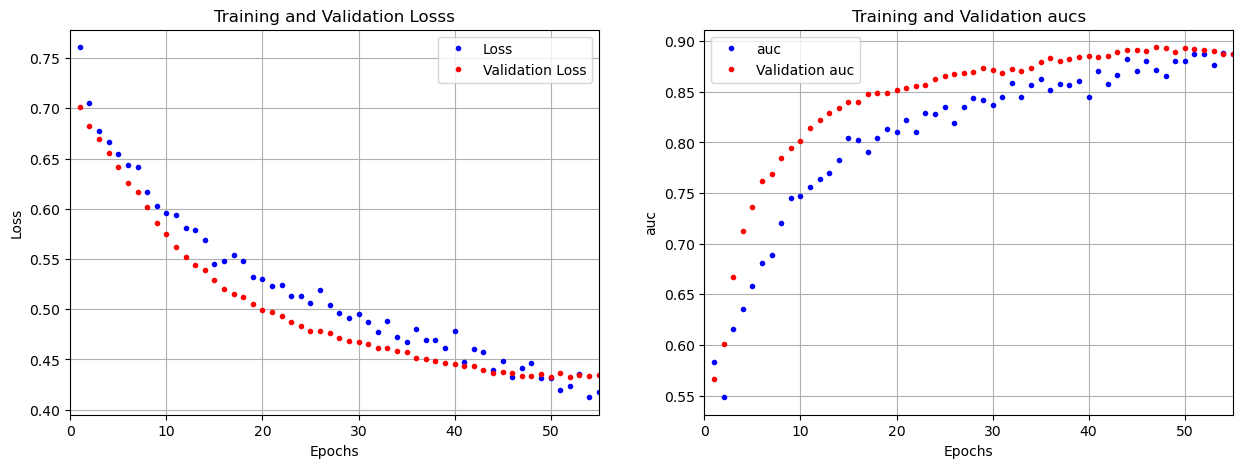

In [155]:
plot_training_history(trained_slp_model['history'], monitors=['loss', 'auc'])

 ## Scaling up: developing a model that overfits

In [156]:
mlp_model = deep_neural_network(hidden_layers=3, hidden_neurons=8,
                                activation='relu',
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_DIMENSION,
                                optimizer=OPTIMIZER, loss=LOSS_FUNC, 
                                metrics=METRICS,
                                name='Multi_Layer_Perceptron')

mlp_model.summary()

Model: "Multi_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_178 (Dense)           (None, 8)                 496       
                                                                 
 dense_179 (Dense)           (None, 8)                 72        
                                                                 
 dense_180 (Dense)           (None, 8)                 72        
                                                                 
 dense_181 (Dense)           (None, 1)                 9         
                                                                 
Total params: 649
Trainable params: 649
Non-trainable params: 0
_________________________________________________________________


## 6. Scaling Up: Developing a Model That Overfits

Testing if a larger model can capture more complex patterns in the SMOTE-balanced data.

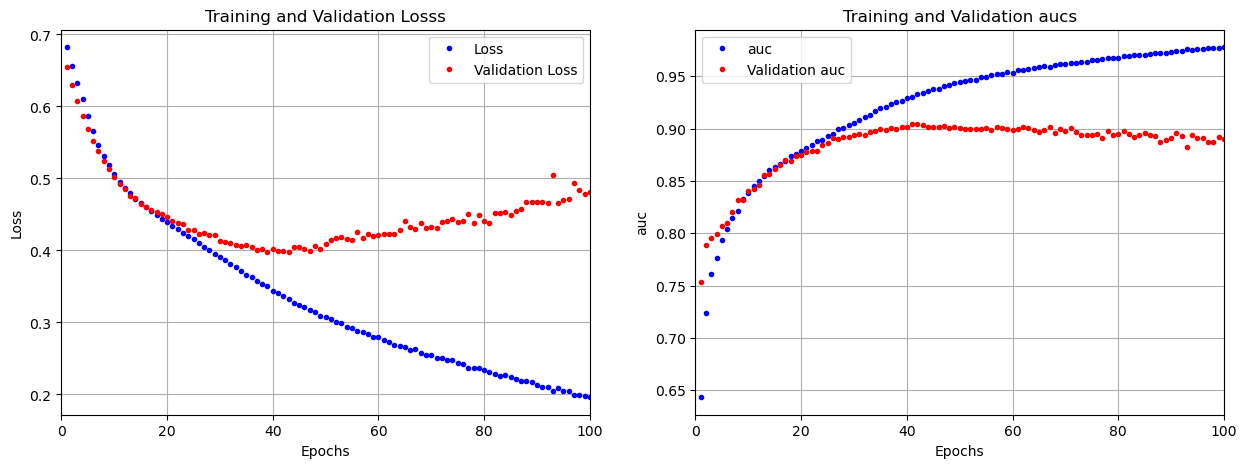

In [158]:
plot_training_history(trained_mlp_model['history'], monitors=['loss', 'auc'])

In [182]:
print('Accuracy (Balanced Validation): {:.2f} (baseline=0.5)'.format(trained_mlp_model['val_score'][0]))
print('Precision (Balanced Validation): {:.2f}'.format(trained_mlp_model['val_score'][1]))
print('Recall (Balanced Validation): {:.2f}'.format(trained_mlp_model['val_score'][2]))
print('AUC (Balanced Validation): {:.2f}'.format(trained_mlp_model['val_score'][3]))

Accuracy (Balanced Validation): 0.80 (baseline=0.5)
Precision (Balanced Validation): 0.79
Recall (Balanced Validation): 0.82
AUC (Balanced Validation): 0.89


In [160]:
preds = trained_mlp_model['model'].predict(X_val, verbose=0)

print('Accuracy (Imbalanced Validation): {:.2f} (baseline=0.7)'.format(accuracy_score(y_val, (preds > 0.5).astype('int32'))))
print('Precision (Imbalanced Validation): {:.2f}'.format(precision_score(y_val, (preds > 0.5).astype('int32'))))
print('Recall (Imbalanced Validation): {:.2f}'.format(recall_score(y_val, (preds > 0.5).astype('int32'))))
print('AUC (Imbalanced Validation): {:.2f}'.format(roc_auc_score(y_val, preds)))
print('Balanced Accuracy (Validation): {:.2f} (baseline = 0.5)'.format(balanced_accuracy_score(y_val, (preds > 0.5).astype('int32'))))

Accuracy (Imbalanced Validation): 0.67 (baseline=0.7)
Precision (Imbalanced Validation): 0.46
Recall (Imbalanced Validation): 0.63
AUC (Imbalanced Validation): 0.67
Balanced Accuracy (Validation): 0.66 (baseline = 0.5)


## 7. Regularizing Your Model and Tuning Hyperparameters

Using **Hyperband** for efficient hyperparameter tuning with a frozen architecture.

### Why Hyperband?

**Hyperband** is more efficient than grid search because it:
1. Starts training many configurations for a few epochs
2. Eliminates poor performers early
3. Allocates more resources to promising configurations

In [ ]:
# Hyperband Model Builder for Binary Classification (SMOTE)
def build_model_hyperband(hp):
    """
    Build German Credit model with FROZEN architecture (2 layers: 16 -> 8 neurons).
    Only tunes regularization (Dropout) and learning rate.
    """
    model = keras.Sequential()
    model.add(layers.Input(shape=(INPUT_DIMENSION,)))

    # Fixed architecture: 2 hidden layers with 16 and 8 neurons
    # Layer 1: 16 neurons
    model.add(layers.Dense(16, activation='relu'))
    drop_0 = hp.Float('drop_0', 0.0, 0.5, step=0.1)
    model.add(layers.Dropout(drop_0))

    # Layer 2: 8 neurons
    model.add(layers.Dense(8, activation='relu'))
    drop_1 = hp.Float('drop_1', 0.0, 0.5, step=0.1)
    model.add(layers.Dropout(drop_1))

    # Output layer for binary classification
    model.add(layers.Dense(OUTPUT_DIMENSION, activation='sigmoid'))

    lr = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=LOSS_FUNC,
        metrics=METRICS
    )
    return model

# Configure Hyperband tuner
tuner = kt.Hyperband(
    build_model_hyperband,
    objective='val_auc',
    max_epochs=20,
    factor=3,
    directory='german_credit_hyperband',
    project_name='german_credit_tuning'
)

# Run Hyperband search on SMOTE-balanced data
tuner.search(
    Xs_train, ys_train,
    validation_data=(Xs_val, ys_val),
    epochs=20,
    batch_size=batch_size
)

In [100]:
KFOLDS = 5

In [165]:
stats.sort_values(by=['auc'], ascending=False)

,hidden_layers,neurons,activation,dropout,batch_size,epochs,val_loss,accuracy,precision,recall,auc
2,3,8,relu,0.25,32,50.8,0.498454,0.72125,0.494348,0.262500,0.794773
0,1,8,relu,0.25,32,47.4,0.488182,0.76000,0.651152,0.429167,0.794494
1,2,8,relu,0.25,32,57.4,0.494724,0.73875,0.607385,0.362500,0.788765
3,4,8,relu,0.25,32,50.0,0.518871,0.70000,0.000000,0.000000,0.773475
4,5,8,relu,0.25,32,52.4,0.522810,0.72125,0.271795,0.133333,0.763151
5,6,8,relu,0.25,32,58.6,0.519334,0.71750,0.242424,0.166667,0.762463
6,7,8,relu,0.25,32,58.8,0.532350,0.70250,0.133333,0.016667,0.759338
7,8,8,relu,0.25,32,47.8,0.553102,0.70750,0.133333,0.050000,0.735733


In [175]:
trained_opt_model = train_deep_neural_network(opt_model, Xs_train, ys_train,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(Xs_val, ys_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

In [183]:
print('Accuracy (Balanced Validation): {:.2f} (baseline=0.5)'.format(trained_opt_model['val_score'][0]))
print('Precision (Balanced Validation): {:.2f}'.format(trained_opt_model['val_score'][1]))
print('Recall (Balanced Validation): {:.2f}'.format(trained_opt_model['val_score'][2]))
print('AUC (Balanced Validation): {:.2f}'.format(trained_opt_model['val_score'][3]))

Accuracy (Balanced Validation): 0.79 (baseline=0.5)
Precision (Balanced Validation): 0.80
Recall (Balanced Validation): 0.78
AUC (Balanced Validation): 0.88


In [ ]:
# Get best hyperparameters and build best model
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(f"  Dropout Layer 1: {best_hp.get('drop_0')}")
print(f"  Dropout Layer 2: {best_hp.get('drop_1')}")
print(f"  Learning Rate: {best_hp.get('lr')}")

opt_model = tuner.hypermodel.build(best_hp)
opt_model.summary()

In [ ]:
# Train the best model on SMOTE-balanced data
history_opt = opt_model.fit(
    Xs_train, ys_train,
    validation_data=(Xs_val, ys_val),
    epochs=50,
    batch_size=batch_size,
    verbose=1
)

trained_opt_model = {
    'model': opt_model,
    'val_score': opt_model.evaluate(Xs_val, ys_val, verbose=0)[1:],
    'history': history_opt
}

In [186]:
print('Balanced Accuracy (Imbalanced Test): {:.2f} (baseline = 0.5)'.format(balanced_accuracy_score(y_test, 
                                                                                         (preds > 0.5).astype('int32'))))

Balanced Accuracy (Imbalanced Test): 0.72 (baseline = 0.5)


---

## 8. Key Takeaways and Observations

### Key Lessons Learned

1. **SMOTE vs. Class Weights:**
   - SMOTE creates synthetic samples, physically balancing the training set
   - Class weights adjust the loss function mathematically
   - Both can be effective; SMOTE works well for small minority classes

2. **Critical: Train on Balanced, Validate on Imbalanced:**
   - Training on SMOTE-balanced data teaches the model to recognize minority patterns
   - Validating on original imbalanced data reflects real-world performance
   - Never SMOTE your validation/test sets!

3. **SMOTE Works Best After Preprocessing:**
   - Apply SMOTE after one-hot encoding and scaling
   - This allows SMOTE to create meaningful synthetic samples in feature space

4. **Hyperparameter Tuning Still Matters:**
   - Even with balanced data, dropout and architecture choices affect performance
   - Use cross-validation to get reliable estimates

### When to Use SMOTE vs. Class Weights

| Scenario | Recommended Approach |
|----------|---------------------|
| Very small minority class (<5%) | SMOTE |
| Moderate imbalance (20-40%) | Either works |
| Computational constraints | Class Weights |
| High-dimensional data | Class Weights (SMOTE can create noise) |